# 과제: 자전거 대여 수요 예측 경진대회 모델 성능 개선

- [자전거 대여 수요 예측 경진대회 링크](https://www.kaggle.com/c/bike-sharing-demand)

- [모델링 코드 참고 링크](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

수강생분의 이름과 학번을 입력해주세요.

In [17]:
print("김현민", "20197125")

김현민 20197125


In [18]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링

### 이상치 제거

In [19]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [20]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가

In [21]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

### 필요 없는 피처 제거

In [22]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [23]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 평가지표 계산 함수 작성

In [24]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

# 5. 성능 개선 I : 릿지 회귀 모델

## 5.1 하이퍼 파라미터 최적화(모델 훈련)

### 모델 생성

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 그리드서치 객체 생성

In [26]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

### 그리드서치 수행

In [27]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [28]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


## 5.2 성능 검증

In [29]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


# 6. 성능 개선 II : 라쏘 회귀 모델

## 6.1 하이퍼 파라미터 최적화(모델 훈련)

In [30]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


## 6.2 성능 검증

In [31]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


# 7. 성능 개선 III : 랜덤 포레스트 회귀 모델

## 7.1 하이퍼 파라미터 최적화(모델 훈련)

In [32]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


## 7.2 모델 성능 검증

In [33]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


## 7.3 예측 및 결과 제출

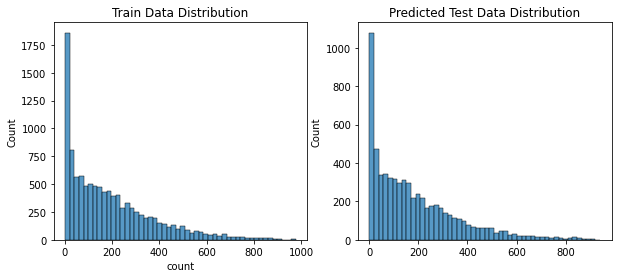

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [35]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

# 실습 과제: 개선시도 3가지, 0.39567 보다 낮은 score 달성
아래의 3가지를 모두 개선 시도하여 0.39567 보다 낮은 score를 달성하시오. 과제로 제공한 코드를 기반으로 다른 캐글 코드의 일부 내용을 참고하여 수정하는 것은 허용합니다.

* 1) 피처 엔지니어링
* 2) 모델 선택
* 3) 하이퍼파라미터 최적화

성능 개선 시도한 내용 간략히 작성해주세요.
* 1) 피처 엔지니어링: 수행한 내용 작성
* 2) 모델 선택: 수행한 내용 작성
* 3) 하이퍼파라미터 최적화: 수행한 내용 작성

0.39567 보다 낮은 score 달성한 성능 증빙자료는 과제함에 제출해주세요.

# 1. 피처엔지니어링
- 미국의 공휴일에는 공공자전거 이용률이 낮을것이므로 이에대해 상대적으로 낮은값을 부여해야된다고 생각하여 제출자료에 0.5를 곱해주었음
- 현충일, 크리스마스 이브/당일, 추수감사절

In [36]:
#미국 현충일
submission.iloc[1258:1269, 1]= submission.iloc[1258:1269, 1]*0.5
submission.iloc[4492:4515, 1]= submission.iloc[4492:4515, 1]*0.5
#크리스마스 이브
submission.iloc[6308:6330, 1]= submission.iloc[6308:6330, 1]*0.5
submission.iloc[3041:3063, 1]= submission.iloc[3041:3063, 1]*0.5
#크리스마스
submission.iloc[6332:6354, 1]= submission.iloc[6332:6354, 1]*0.5
submission.iloc[3065:3087, 1]= submission.iloc[3065:3087, 1]*0.5
#추수감사절
submission.iloc[5992:6015, 1]= submission.iloc[5992:6015, 1]*0.5
submission.iloc[2771:2794, 1]= submission.iloc[2771:2794, 1]*0.5

In [37]:
submission.to_csv("submission_without_holiday.csv", index=False)

### Score : 0.38243
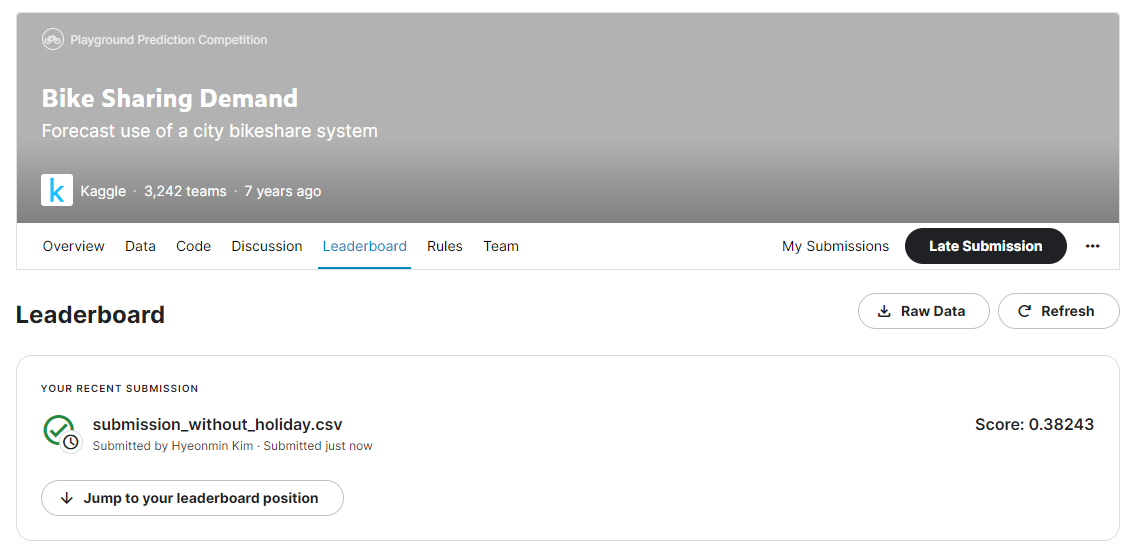

# 2. 모델선택
- lgbm 모델을 사용

In [122]:
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [124]:
train["year"] = train["datetime"].dt.year

AttributeError: Can only use .dt accessor with datetimelike values

#### 에러발생. datetime 객체로 변환해주었음

In [125]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [127]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


#### dt객체를 활용하여 datetime 객체를 년/월/요일로 분리해주었음

In [128]:
train["year"] = train["datetime"].dt.year
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek

test["year"] = test["datetime"].dt.year
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek

In [129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  hour        10886 non-null  int64         
 14  dayofweek   10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(11)
memory usage: 1.2 MB


In [130]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5


In [132]:
# 로그 정규화 진행. log1p는 log(1+val) 과 같음
# log를 사용하게되면 inf값을 가지게 되어 exp와 같은 메서드를 활용 불가
y_casual = np.log1p(train.casual)
y_registered = np.log1p(train.registered)

# 불필요한 피처 제거
train.drop(["datetime", "windspeed", "casual", "registered", "count"], 1, inplace=True)
test.drop(["datetime", "windspeed", ], 1, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'casual'

In [133]:
y_casual

0        1.386294
1        2.197225
2        1.791759
3        1.386294
4        0.000000
           ...   
10881    2.079442
10882    2.397895
10883    1.609438
10884    2.564949
10885    1.609438
Name: casual, Length: 10886, dtype: float64

In [134]:
y_registered

0        2.639057
1        3.496508
2        3.332205
3        2.397895
4        0.693147
           ...   
10881    5.799093
10882    5.446737
10883    5.105945
10884    4.770685
10885    4.442651
Name: registered, Length: 10886, dtype: float64

In [116]:
#lgbm 모델 사용
import lightgbm as lgb
hyperparameters = { 'colsample_bytree': 0.725,  'learning_rate': 0.013,
                    'num_leaves': 56, 'reg_alpha': 0.754, 'reg_lambda': 0.071, 
                    'subsample': 0.523, 'n_estimators': 1093}
model = lgb.LGBMRegressor(**hyperparameters)
#target 은 y_casual
model.fit(train, y_casual)
preds1 = model.predict(test)

hyperparameters = { 'colsample_bytree': 0.639,  'learning_rate': 0.011,
                    'num_leaves': 30, 'reg_alpha': 0.351, 'reg_lambda': 0.587,
                   'subsample': 0.916, 'n_estimators': 2166}
model = lgb.LGBMRegressor(**hyperparameters, )
#target은 y_registered
model.fit(train, y_registered)
preds2 = model.predict(test)



In [119]:
submission = pd.read_csv(data_path + 'sampleSubmission.csv')
#expm1은 exp(val-1)
submission["count"] = np.expm1(preds1) + np.expm1(preds2)
submission.to_csv("submission_lgbm.csv", index=False)

# score : 0.37557
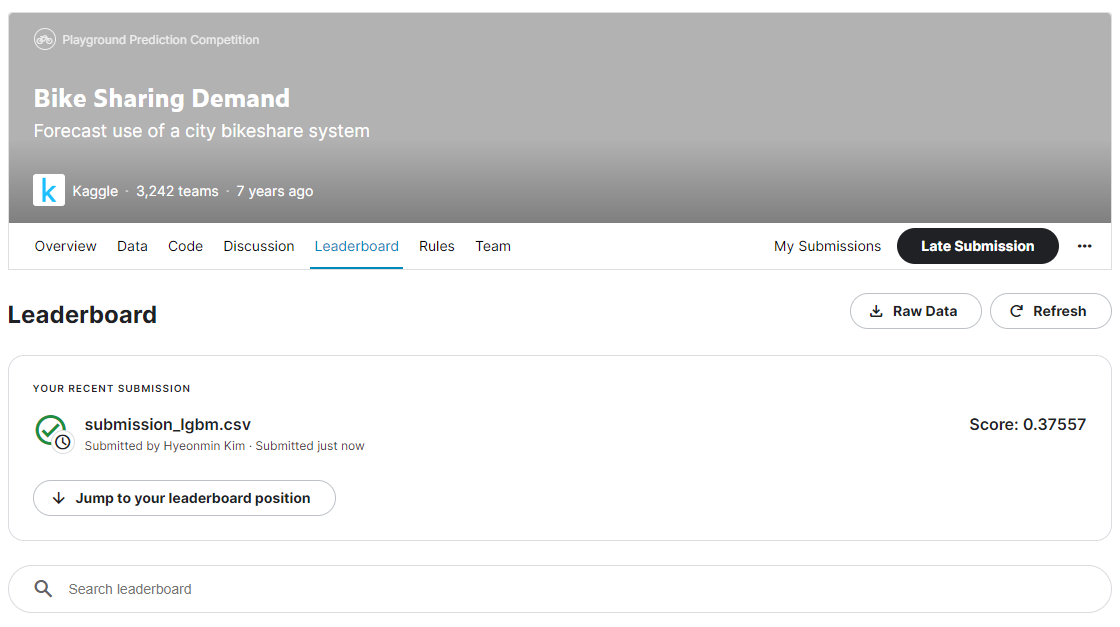

# 3. 하이퍼 파라미터 조정
 - lgbm 모델의 파라미터 조정
 - learningrate를 줄이고 n_estimators를 높임

In [139]:
#lgbm 모델 사용
import lightgbm as lgb
hyperparameters = { 'colsample_bytree': 0.725,  'learning_rate': 0.011,
                    'num_leaves': 56, 'reg_alpha': 0.754, 'reg_lambda': 0.071, 
                    'subsample': 0.523, 'n_estimators': 1493}
model = lgb.LGBMRegressor(**hyperparameters)
#target 은 y_casual
model.fit(train, y_casual)
preds1 = model.predict(test)

hyperparameters = { 'colsample_bytree': 0.639,  'learning_rate': 0.009,
                    'num_leaves': 30, 'reg_alpha': 0.351, 'reg_lambda': 0.587,
                   'subsample': 0.916, 'n_estimators': 2566}
model = lgb.LGBMRegressor(**hyperparameters, )
#target은 y_registered
model.fit(train, y_registered)
preds2 = model.predict(test)

In [140]:
submission = pd.read_csv(data_path + 'sampleSubmission.csv')
#expm1은 exp(val-1)
submission["count"] = np.expm1(preds1) + np.expm1(preds2)
submission.to_csv("submission_lgbm_parameter.csv", index=False)

# Score : 0.37524
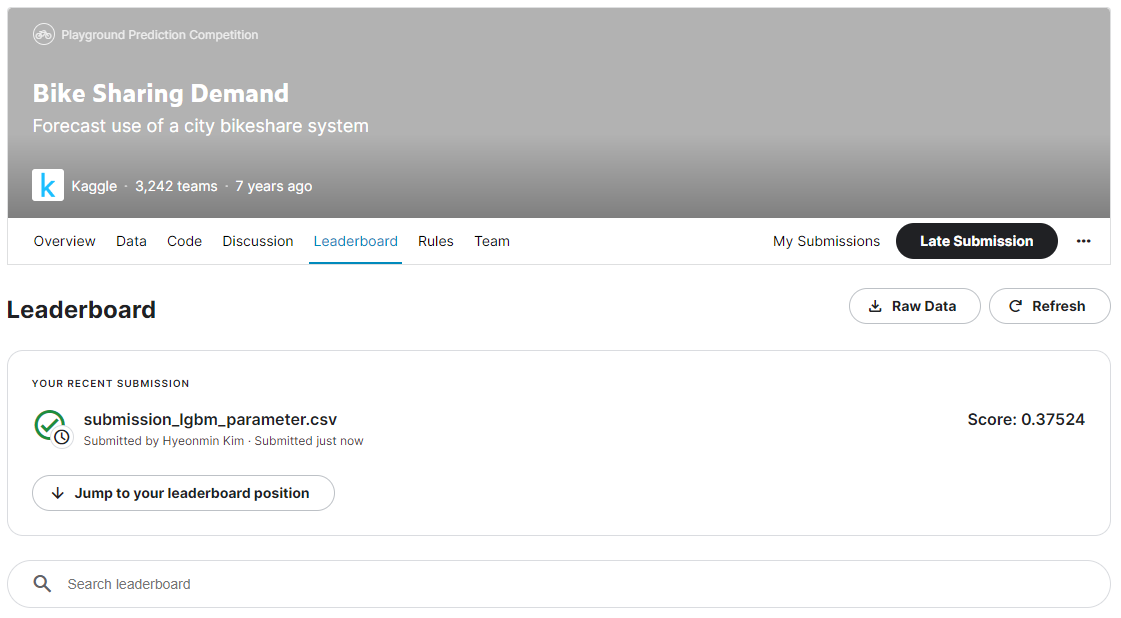

# 조금더 조정

In [141]:
hyperparameters = { 'colsample_bytree': 0.725,  'learning_rate': 0.009,
                    'num_leaves': 56, 'reg_alpha': 0.754, 'reg_lambda': 0.071, 
                    'subsample': 0.523, 'n_estimators': 1793}
model = lgb.LGBMRegressor(**hyperparameters)
#target 은 y_casual
model.fit(train, y_casual)
preds1 = model.predict(test)

hyperparameters = { 'colsample_bytree': 0.639,  'learning_rate': 0.007,
                    'num_leaves': 30, 'reg_alpha': 0.351, 'reg_lambda': 0.587,
                   'subsample': 0.916, 'n_estimators': 2866}
model = lgb.LGBMRegressor(**hyperparameters, )
#target은 y_registered
model.fit(train, y_registered)
preds2 = model.predict(test)

In [142]:
submission = pd.read_csv(data_path + 'sampleSubmission.csv')
#expm1은 exp(val-1)
submission["count"] = np.expm1(preds1) + np.expm1(preds2)
submission.to_csv("submission_lgbm_parameter.csv", index=False)

# Score : 0.37421
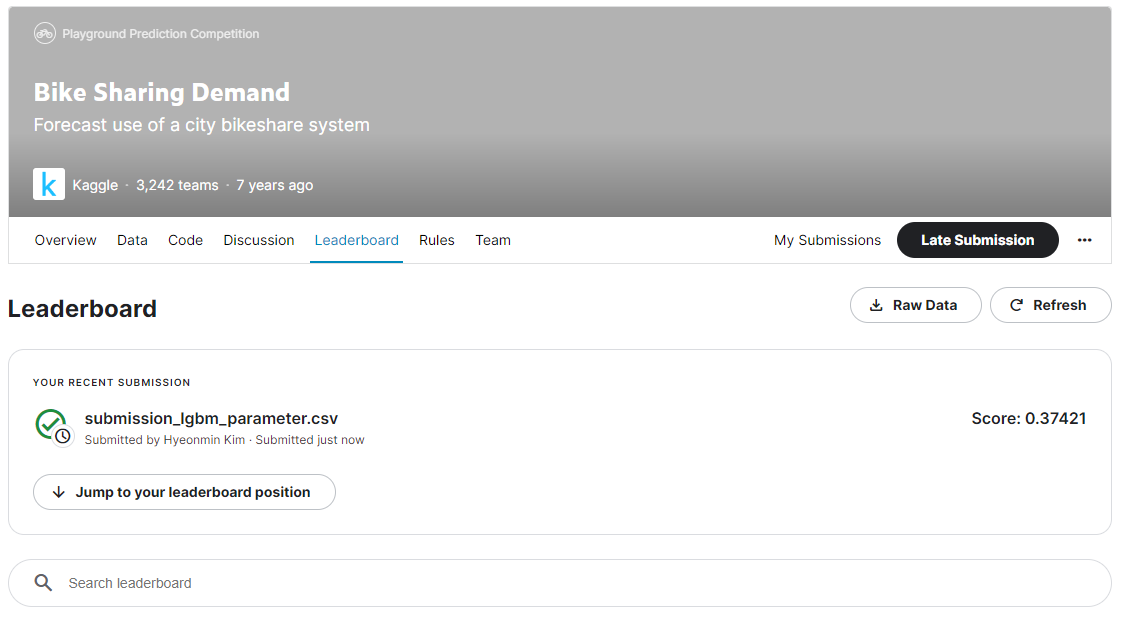

## 정리
 - baseline code score : 0.39567
 - 피처 엔지니어링
     - 베이스라인 코드에 공휴일 데이터를 활용하여 일부 값을 조정
     - score : 0.38243
 - 모델선택
     - lgbm모델 사용
     - score : 0.37557
 - 하이퍼파라미터 조정
     - lgbm모델의 파라미터 조정
     - learning rate와 n_estimators 조정
     - 1차 score : 0.37524
     - 2차 score : 0.37421